# **Homework 10 - Adversarial Attack**

Slides: https://reurl.cc/v5kXkk

Videos:

TA: ntu-ml-2021spring-ta@googlegroups.com

In [2]:
# download
!gdown --id 1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX -O data.zip

Downloading...
From: https://drive.google.com/uc?id=1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX
To: /content/data.zip
100% 490k/490k [00:00<00:00, 71.6MB/s]


In [1]:
!nvidia-smi

Thu May 27 07:23:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Enviroment & Download

We make use of [pytorchcv](https://pypi.org/project/pytorchcv/) to obtain CIFAR-10 pretrained model, so we need to set up the enviroment first. We also need to download the data (200 images) which we want to attack.

In [3]:
# set up environment
!pip install pytorchcv

# unzip
!unzip ./data.zip
!rm ./data.zip

     |████████████████████████████████| 532kB 13.8MB/s 
Archive:  ./data.zip
   creating: data/
   creating: data/deer/
 extracting: data/deer/deer13.png    
 extracting: data/deer/deer6.png     
 extracting: data/deer/deer11.png    
 extracting: data/deer/deer2.png     
 extracting: data/deer/deer10.png    
 extracting: data/deer/deer16.png    
 extracting: data/deer/deer9.png     
 extracting: data/deer/deer20.png    
 extracting: data/deer/deer15.png    
 extracting: data/deer/deer19.png    
 extracting: data/deer/deer5.png     
 extracting: data/deer/deer14.png    
 extracting: data/deer/deer4.png     
 extracting: data/deer/deer8.png     
 extracting: data/deer/deer12.png    
 extracting: data/deer/deer1.png     
 extracting: data/deer/deer7.png     
 extracting: data/deer/deer17.png    
 extracting: data/deer/deer18.png    
 extracting: data/deer/deer3.png     
   creating: data/horse/
 extracting: data/horse/horse9.png   
 extracting: data/horse/horse1.png   
 extracting: data/h

## Global Settings

* $\epsilon$ is fixed to be 8. But on **Data section**, we will first apply transforms on raw pixel value (0-255 scale) **by ToTensor (to 0-1 scale)** and then **Normalize (subtract mean divide std)**. $\epsilon$ should be set to $\frac{8}{255 * std}$ during attack.

* Explaination (optional)
    * Denote the first pixel of original image as $p$, and the first pixel of adversarial image as $a$.
    * The $\epsilon$ constraints tell us $\left| p-a \right| <= 8$.
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.
    * After applying ToTensor() and Normalize() on $p$ and $a$, the constraint becomes $\left| N(T(p))-N(T(a)) \right| = \left| \frac{\frac{p}{255}-mean}{std}-\frac{\frac{a}{255}-mean}{std} \right| = \frac{1}{255 * std} \left| p-a \right| <= \frac{8}{255 * std}.$
    * So, we should set $\epsilon$ to be $\frac{8}{255 * std}$ after ToTensor() and Normalize().

In [4]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

print("mean:", mean, "\nstd:", std)

epsilon = 8/255/std
# TODO: iterative fgsm attack
# alpha (step size) can be decided by yourself
alpha = 2/255/std

root = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

mean: tensor([[[0.4910]],

        [[0.4820]],

        [[0.4470]]], device='cuda:0') 
std: tensor([[[0.2020]],

        [[0.1990]],

        [[0.2010]]], device='cuda:0')


## Data

Construct dataset and dataloader from root directory. Note that we store the filename of each image for future usage.

In [5]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        '''
        data_dir
        ├── class_dir
        │   ├── class1.png
        │   ├── ...
        │   ├── class20.png
        '''
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Utils -- Benign Images Evaluation

In [6]:
# to evaluate the performance of model on benign images
def epoch_benign(model, num_model, loader, loss_fn, num_loss):
    for i in range(num_model):
        model[i].eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        model_box = []
        for i in range(num_model):
            yp = model[i](x)
            loss_box = []
            for j in range(num_loss):
                loss_box.append(loss_fn[j](yp, y))
            model_box.append(sum(loss_box) / num_loss)
        loss = sum(model_box) / num_model
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

## Utils -- Attack Algorithm

In [7]:
# perform fgsm attack
def fgsm(model, num_model, x, y, loss_fn, num_loss, epsilon=epsilon):
    x_adv = x.detach().clone() # initialize x_adv as original benign image x
    x_adv.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
    model_box = []
    for i in range(num_model):
        loss_box = []
        for j in range(num_loss):
            loss_box.append(loss_fn[j](model[i](x_adv), y))
        model_box.append(sum(loss_box) / num_loss)
    loss = sum(model_box) / num_model
    loss.backward() # calculate gradient
    # fgsm: use gradient ascent on x_adv to maximize loss
    x_adv = x_adv + epsilon * x_adv.grad.detach().sign()
    return x_adv

# TODO: perform iterative fgsm attack
# set alpha as the step size in Global Settings section
# alpha and num_iter can be decided by yourself
def ifgsm(model, num_model, x, y, loss_fn, num_loss, epsilon=epsilon, alpha=alpha, num_iter=100):
    x_adv = x.detach().clone()
    for i in range(num_iter):
        x_adv = fgsm(model, num_model, x_adv, y, loss_fn, num_loss, alpha)
        x_adv = torch.min(torch.max(x_adv, x - epsilon), x + epsilon)
    return x_adv

## Utils -- Attack

* Recall
    * ToTensor() can be seen as a function where $T(x) = x/255$.
    * Normalize() can be seen as a function where $N(x) = (x-mean)/std$ where $mean$ and $std$ are constants.

* Inverse function
    * Inverse Normalize() can be seen as a function where $N^{-1}(x) = x*std+mean$ where $mean$ and $std$ are constants.
    * Inverse ToTensor() can be seen as a function where $T^{-1}(x) = x*255$.

* Special Noted
    * ToTensor() will also convert the image from shape (height, width, channel) to shape (channel, height, width), so we also need to transpose the shape back to original shape.
    * Since our dataloader samples a batch of data, what we need here is to transpose **(batch_size, channel, height, width)** back to **(batch_size, height, width, channel)** using np.transpose.

In [8]:
# perform adversarial attack and generate adversarial examples
def gen_adv_examples(model, num_model, loader, attack, loss_fn, num_loss):
    for i in range(num_model):
        model[i].eval()
    adv_names = []
    train_acc, train_loss = 0.0, 0.0
    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        x_adv = attack(model, num_model, x, y, loss_fn, num_loss) # obtain adversarial examples
        model_box = []
        for j in range(num_model):
            yp = model[j](x_adv)
            loss_box = []
            for k in range(num_loss):
                loss_box.append(loss_fn[k](yp, y))
            model_box.append(sum(loss_box) / num_loss)
        loss = sum(model_box) / num_model
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
        # store adversarial examples
        adv_ex = ((x_adv) * std + mean).clamp(0, 1) # to 0-1 scale
        adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
        adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
        adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]
    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

## Model / Loss Function

Model list is available [here](https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/model_provider.py). Please select models which has _cifar10 suffix. Some of the models cannot be accessed/loaded. You can safely skip them since TA's model will not use those kinds of models.

In [30]:
from pytorchcv.model_provider import get_model as ptcv_get_model

model = [ptcv_get_model('nin_cifar10', pretrained=True).to(device),
         ptcv_get_model('resnet110_cifar10', pretrained=True).to(device),
         ptcv_get_model('resnext272_2x32d_cifar10', pretrained=True).to(device),
         ptcv_get_model('seresnet110_cifar10', pretrained=True).to(device),
         ptcv_get_model('pyramidnet110_a270_cifar10', pretrained=True).to(device),
         ptcv_get_model('densenet100_k12_bc_cifar10', pretrained=True).to(device),
         ptcv_get_model('xdensenet40_2_k36_bc_cifar10', pretrained=True).to(device),
         ptcv_get_model('wrn40_8_cifar10', pretrained=True).to(device),
         ptcv_get_model('ror3_110_cifar10', pretrained=True).to(device),
         ptcv_get_model('rir_cifar10', pretrained=True).to(device),
         ptcv_get_model('diaresnet110_cifar10', pretrained=True).to(device),
        ]
num_model = len(model)
loss_fn = [nn.CrossEntropyLoss(), nn.NLLLoss(), nn.MultiMarginLoss()]
num_loss = len(loss_fn)

benign_acc1, benign_loss1 = epoch_benign(model, num_model, adv_loader, loss_fn, num_loss)
print(f'benign_acc = {benign_acc1:.5f}, benign_loss = {benign_loss1:.5f}')

benign_acc = 0.96500, benign_loss = -1.63260


## FGSM

In [31]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, num_model, adv_loader, fgsm, loss_fn, num_loss)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, 'fgsm', adv_examples, adv_names)

fgsm_acc = 0.64000, fgsm_loss = -0.14857


## I-FGSM

In [32]:
# TODO: iterative fgsm attack
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(model, num_model, adv_loader, ifgsm, loss_fn, num_loss)
print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, 'ifgsm', adv_examples, adv_names)

ifgsm_acc = 0.00000, ifgsm_loss = 10.11941


## Compress the images

In [33]:
#%cd fgsm
#!tar zcvf ../fgsm.tgz *
#%cd ..

%cd ifgsm
!tar zcvf ../ifgsm.tgz *
%cd ..

/content/ifgsm
airplane/
airplane/airplane11.png
airplane/airplane19.png
airplane/airplane17.png
airplane/airplane6.png
airplane/airplane10.png
airplane/airplane12.png
airplane/airplane20.png
airplane/airplane8.png
airplane/airplane16.png
airplane/airplane14.png
airplane/airplane1.png
airplane/airplane2.png
airplane/airplane13.png
airplane/airplane3.png
airplane/airplane4.png
airplane/airplane18.png
airplane/airplane7.png
airplane/airplane15.png
airplane/airplane9.png
airplane/airplane5.png
automobile/
automobile/automobile16.png
automobile/automobile18.png
automobile/automobile3.png
automobile/automobile10.png
automobile/automobile19.png
automobile/automobile13.png
automobile/automobile17.png
automobile/automobile15.png
automobile/automobile11.png
automobile/automobile9.png
automobile/automobile20.png
automobile/automobile8.png
automobile/automobile2.png
automobile/automobile4.png
automobile/automobile7.png
automobile/automobile1.png
automobile/automobile12.png
automobile/automobile14

## Visualization

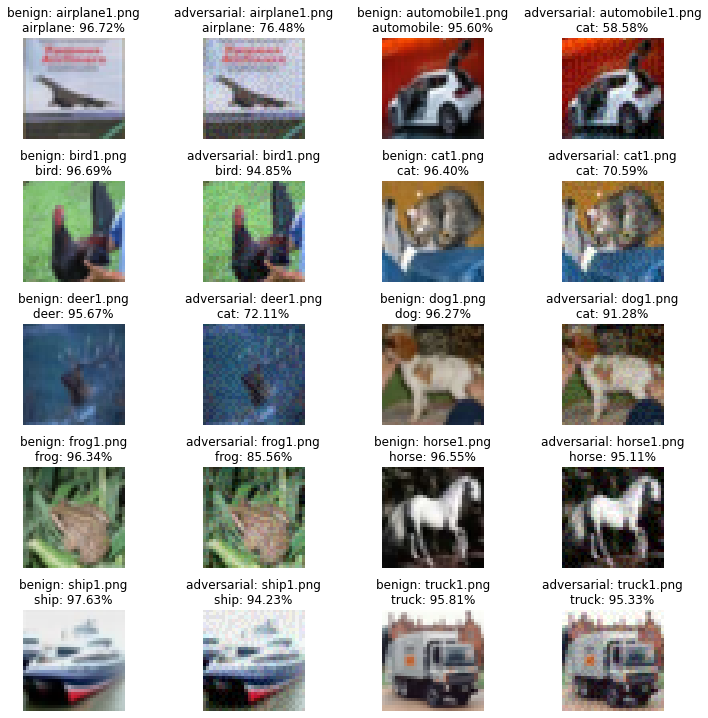

In [34]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    #logit = model1(transform(im).unsqueeze(0).to(device))[0]
    logit_box = []
    for j in range(num_model):
        logit_box.append(model[j](transform(im).unsqueeze(0).to(device))[0])
    logit = sum(logit_box) / num_model
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./fgsm/{path}')
    #logit = model1(transform(im).unsqueeze(0).to(device))[0]
    logit_box = []
    for j in range(num_model):
        logit_box.append(model[j](transform(im).unsqueeze(0).to(device))[0])
    logit = sum(logit_box) / num_model
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()